# Define constants

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline

input_path = './chest_Xray/'
img_dims = 150
epochs = 10
batch_size = 96

def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)

    # This is fed to the network in the specified batch sizes and image dimensions
    # Allows for faster and lighter imports
    train_gen = train_datagen.flow_from_directory(
        directory=input_path+'train',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

    test_gen = test_datagen.flow_from_directory(
        directory=input_path+'test',
        target_size=(img_dims, img_dims),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

# Import and process data

In [2]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(
        _set, n_normal, n_infect))

train_gen, test_gen, test_data, test_labels = process_data(
    img_dims, batch_size)

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Setup CNN

### Using 5 convolution Layers and 3 fully connected Layers

In [3]:

from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential

model = Sequential()

# First Layer
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D())

# Second Layer
model.add(SeparableConv2D(32, (3, 3), activation='relu', padding='same')) # Instead of 1 2D conv we do the equivalent of 2 1D conv
model.add(SeparableConv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization()) # Normalize inputs to avoid internal covariate shift
model.add(MaxPool2D())

# Third Layer
model.add(SeparableConv2D(64, (3, 3), activation='relu', padding='same'))
model.add(SeparableConv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())

# Fourth Layer
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))

# Fifth Layer
model.add(SeparableConv2D(256, (3, 3), activation='relu', padding='same'))
model.add(SeparableConv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.2))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

# Define Callbacks

In [4]:
from Class.callback import EarlyStoppingAtMinLoss
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint(
    filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(
    monitor='val_loss', min_delta=0.1, patience=4, mode='min')
# early_stop = EarlyStoppingAtMinLoss(4)

# Train CNN

### Use train and validate datasets

In [5]:
hist = model.fit(
    train_gen, steps_per_epoch=train_gen.samples // batch_size,
    epochs=epochs, validation_data=test_gen,
    validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

=============================] - 105s 3s/step - loss: 0.1577 - accuracy: 0.9407 - val_loss: 1.2865 - val_accuracy: 0.6133

Epoch 00019: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
Epoch 20/40
40/40 [==============================] - 104s 3s/step - loss: 0.1661 - accuracy: 0.9400 - val_loss: 0.8874 - val_accuracy: 0.6758
Epoch 21/40
40/40 [==============================] - 105s 3s/step - loss: 0.1671 - accuracy: 0.9402 - val_loss: 0.5576 - val_accuracy: 0.8027

Epoch 00021: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
Epoch 22/40
40/40 [==============================] - 108s 3s/step - loss: 0.1570 - accuracy: 0.9448 - val_loss: 0.4343 - val_accuracy: 0.8516
Epoch 23/40
40/40 [==============================] - 108s 3s/step - loss: 0.1579 - accuracy: 0.9423 - val_loss: 0.3932 - val_accuracy: 0.8711

Epoch 00023: ReduceLROnPlateau reducing learning rate to 2.1870000637136398e-07.
Epoch 24/40
40/40 [==============================] - 106s 3s/step 

# Testing Metrics

### Accuracy and Loss graphs

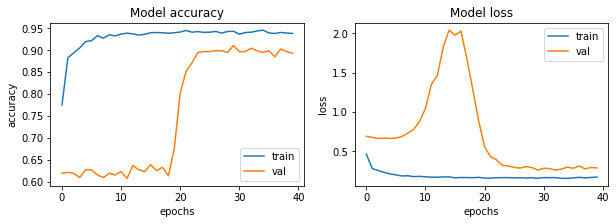

In [6]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Model metrics - Accuracy, F1, Confusion Matrix

TEST METRICS ----------------------
Accuracy: 89.74358974358975%
Precision: 89.95098039215686%
Recall: 94.1025641025641%
F1-score: 91.97994987468671

TRAIN METRIC ----------------------
Train acc: 93.79

CONFUSION MATRIX ------------------
[[193  41]
 [ 23 367]]


<AxesSubplot:>

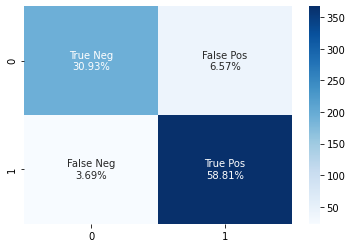

In [7]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('TEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
f = 2 * precision * recall/(precision + recall)
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(f))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

print('\nCONFUSION MATRIX ------------------')
print(cm)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v3}" for v1, v3 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# Save model

In [8]:
model.save('./saved_models_v2/' + str(epochs) + '_adam_b' + str(batch_size) + '_a' + str(int(acc)) + '_f' + str(int(f)))

INFO:tensorflow:Assets written to: ./saved_models_v2/40_adam_b128_a89_f91/assets
